In [1]:
import tensorflow as tf

# # Set GPU memory growth before any operations
# physical_devices = tf.config.list_physical_devices('GPU')
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=21240)]
#         )
#     except RuntimeError as e:
#         print(e)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

!pip uninstall -y kerastuner
!pip install keras-tuner
import keras_tuner as kt
import gc

In [ ]:
file_path_train = f'/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_train_complete.pkl'
with open(file_path_train, 'rb') as file:
    train_data = pickle.load(file)
print(f"Data has been loaded from {file_path_train}")

file_path_val = f'/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_val_complete.pkl'
with open(file_path_val, 'rb') as file:
    val_data = pickle.load(file)
print(f"Data has been loaded from {file_path_val}")

file_path_test = f'/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_test_complete.pkl'
with open(file_path_test, 'rb') as file:
    test_data = pickle.load(file)
print(f"Data has been loaded from {file_path_test}")

Data has been loaded from /content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_train_complete.pkl
Data has been loaded from /content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_val_complete.pkl
Data has been loaded from /content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_test_complete.pkl


In [ ]:
x_train = train_data[0][:, :, :, :2]
y_train = train_data[1][:, :]
print(x_train.shape, y_train.shape)

x_val = val_data[0][:, :, :, :2]
y_val = val_data[1][:, :]
print(x_val.shape, y_val.shape)

x_test = test_data[0][:, :, :, :2]
y_test = test_data[1][:, :]
print(x_test.shape, y_test.shape)

# Ensure data types are compatible with TensorFlow
x_train = tf.cast(x_train, dtype=tf.float32)
y_train = tf.cast(y_train, dtype=tf.float32)
x_val = tf.cast(x_val, dtype=tf.float32)
y_val = tf.cast(y_val, dtype=tf.float32)
x_test = tf.cast(x_val, dtype=tf.float32)
y_test = tf.cast(y_val, dtype=tf.float32)

(74, 551, 20, 2) (74, 551)
(24, 551, 20, 2) (24, 551)
(24, 551, 20, 2) (24, 551)


In [ ]:
def compute_irr_top1(predictions, ground_truth, sample_weight=None):
    top1_indices = tf.argmax(predictions, axis=-1)
    top1_returns = tf.gather(ground_truth, top1_indices, batch_dims=1)
    irr = tf.reduce_mean(top1_returns)
    return irr

def pointwise_regression_loss(predictions, targets, sample_weight=None):
    point_wise_loss = tf.reduce_mean(tf.square(predictions - targets), axis=1)
    total_loss = tf.reduce_sum(point_wise_loss)
    return total_loss

def compute_mrr_top1(predictions, ground_truth, sample_weight=None):
    top1_indices = tf.argmax(predictions, axis=-1)
    top1_ground_truth = tf.gather(ground_truth, top1_indices, batch_dims=1)
    sorted_ground_truth_indices = tf.argsort(ground_truth, axis=-1, direction='DESCENDING')
    ranks = tf.argsort(sorted_ground_truth_indices, axis=-1) + 1
    top1_ranks = tf.gather(ranks, top1_indices, batch_dims=1)
    reciprocal_ranks = tf.where(top1_ground_truth > 0, 1.0 / tf.cast(top1_ranks, tf.float32), 0.0)
    overall_mrr = tf.reduce_mean(reciprocal_ranks)
    return overall_mrr

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dense, Layer, Flatten, LeakyReLU, BatchNormalization
import keras_tuner as kt
import gc

# (Assume x_train, y_train, x_val, y_val, x_test, y_test, pointwise_regression_loss, compute_irr_top1, compute_mrr_top1, and cuda are defined elsewhere)

# Define the strategy
strategy = tf.distribute.MirroredStrategy()

# Simplified TCNLayer Class without gating and residual connections
class TCNLayer(Layer):
    def __init__(self, filters, kernel_size, dilation_rate, stride=1, padding='causal', kernel_initializer='glorot_uniform', **kwargs):
        super(TCNLayer, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.stride = stride
        self.padding = padding
        self.kernel_initializer = kernel_initializer

    def build(self, input_shape):
        self.conv = tf.keras.layers.Conv1D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            dilation_rate=self.dilation_rate,
            strides=self.stride,
            padding=self.padding,
            kernel_initializer=self.kernel_initializer
        )
        self.batch_norm = BatchNormalization()

    def call(self, inputs):
        x = self.conv(inputs)
        return self.batch_norm(x)

# StockTCNBlock Class with kernel_initializer hyperparameter
class StockTCNBlock(Layer):
    def __init__(self, filters, dilation_rates, kernel_size, stride=1, padding='causal', activation='linear', kernel_initializer='glorot_uniform', **kwargs):
        super(StockTCNBlock, self).__init__(**kwargs)
        self.tcn_layers = [
            TCNLayer(filters, kernel_size, dilation_rate=d, stride=stride, padding=padding, kernel_initializer=kernel_initializer)
            for d in dilation_rates
        ]
        self.activation_fn = self._get_activation(activation)

    def _get_activation(self, activation):
        if activation == 'linear':
            return tf.keras.layers.Activation('linear')
        elif activation == 'relu':
            return tf.keras.layers.ReLU()
        elif activation == 'leaky_relu':
            return tf.keras.layers.LeakyReLU()
        else:
            raise ValueError("Invalid activation function")

    def build(self, input_shape):
        for layer in self.tcn_layers:
            layer.build(input_shape)
        self.built = True

    def call(self, inputs):
        x = inputs
        for layer in self.tcn_layers:
            x = layer(x)
        return self.activation_fn(x)

# Simplified TCNModel Class with kernel_initializer hyperparameter passed to sub-layers
class TCNModel(tf.keras.Model):
    def __init__(self, num_stocks, num_timesteps, filters=32, kernel_size=3, stride=1, padding='causal', activation='linear', num_layers=3, kernel_initializer='glorot_uniform', **kwargs):
        super(TCNModel, self).__init__(**kwargs)
        self.num_stocks = num_stocks
        self.filters = filters
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.num_layers = num_layers
        self.kernel_initializer = kernel_initializer
        self.dilation_rates = [2**i for i in range(self.num_layers)]

        self.tcn_blocks = [StockTCNBlock(self.filters, self.dilation_rates, self.kernel_size, self.stride, self.padding, activation=self.activation, kernel_initializer=self.kernel_initializer) for _ in range(self.num_stocks)]
        self.flatten = Flatten()
        self.dense_1 = Dense(64, activation=self.activation, kernel_initializer=self.kernel_initializer)
        self.dense_2 = Dense(1, activation='linear', kernel_initializer=self.kernel_initializer)

    def build(self, input_shape):
        self.num_stocks = input_shape[1]

    def call(self, inputs):
        stock_outputs = []
        for i in range(self.num_stocks):
            stock_input = inputs[:, i, :, :]
            stock_output = self.tcn_blocks[i](stock_input)
            stock_outputs.append(stock_output)
        fused_output = tf.stack(stock_outputs, axis=1)
        last_state = fused_output[:, :, -1, :]
        x = self.flatten(last_state)
        x = self.dense_1(x)
        return self.dense_2(x)

def optimized_custom_loss_function(y_true, y_pred, model, alpha=1.0, lambda_=0.01):
    pointwise_loss = tf.reduce_mean(tf.square(y_pred - y_true))
    batch_size = tf.shape(y_true)[0]
    y_pred_diff = tf.expand_dims(y_pred, 2) - tf.expand_dims(y_pred, 1)
    y_true_diff = tf.expand_dims(y_true, 2) - tf.expand_dims(y_true, 1)
    pairwise_loss = tf.reduce_sum(tf.maximum(0.0, -y_pred_diff * y_true_diff))
    pairwise_loss = alpha * pairwise_loss / tf.cast(batch_size, tf.float32)
    l2_loss = lambda_ * tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])
    loss = pointwise_loss + pairwise_loss + l2_loss
    return loss

class CustomMetric(tf.keras.metrics.Metric):
    def __init__(self, metric_fn, name, **kwargs):
        super(CustomMetric, self).__init__(name=name, **kwargs)
        self.metric_fn = metric_fn
        self.result_value = self.add_weight(name=f"{name}_value", initializer="zeros")
        self.count = self.add_weight(name=f"{name}_count", initializer="zeros")

    def update_state(self, y_true, y_pred, **kwargs):
        value = self.metric_fn(y_pred, y_true, **kwargs)
        self.result_value.assign_add(value)
        self.count.assign_add(1.0)

    def result(self):
        return self.result_value / tf.maximum(self.count, 1.0)

    def reset_states(self):
        self.result_value.assign(0.0)
        self.count.assign(0.0)

metrics = [
    CustomMetric(pointwise_regression_loss, name="pointwise_regression_loss"),
    CustomMetric(compute_irr_top1, name="compute_irr_top1"),
    CustomMetric(compute_mrr_top1, name="compute_mrr_top1")
]

class CustomTCNHyperModel(kt.HyperModel):
    def build(self, hp):
        filters = hp.Choice('filters', [64])
        kernel_size = hp.Choice('kernel_size', [2, 3, 4, 5])
        stride = hp.Choice('stride', [1])
        num_layers = hp.Choice('layers', [3, 4, 5])
        activation = hp.Choice('activation', ['linear', 'relu', 'leaky_relu'])
        learning_rate = hp.Choice('learning_rate', [0.001])
        alpha = hp.Choice('alpha', [1.5])
        lambda_ = hp.Choice('lambda', [0.01, 0.005])
        kernel_initializer_choice = hp.Choice('kernel_initializer', ['glorot_uniform', 'he_normal', 'he_uniform', 'glorot_normal' ])

        with strategy.scope():
            model = TCNModel(
                num_stocks=x_train.shape[1],
                num_timesteps=x_train.shape[2],
                filters=filters,
                kernel_size=kernel_size,
                stride=stride,
                activation=activation,
                num_layers=num_layers,
                kernel_initializer=kernel_initializer_choice
            )
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer,
                          loss=lambda y_true, y_pred: optimized_custom_loss_function(y_true, y_pred, model, alpha=alpha, lambda_=lambda_),
                          metrics=metrics)
        return model

    def run_trial(self, trial, x_train, y_train, x_val, y_val, epochs, batch_size):
        tf.keras.backend.clear_session()
        gc.collect()
        with tf.Graph().as_default():
            with strategy.scope():
                model = self.build(trial.hyperparameters)
                model(tf.random.normal((1, x_train.shape[1], x_train.shape[2], x_train.shape[3])))
            history = model.fit(
                x_train, y_train,
                validation_data=(x_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                verbose=1
            )
            del model
            gc.collect()
            tf.keras.backend.clear_session()
            device = cuda.get_current_device()
            device.reset()
        return history

tuner = kt.RandomSearch(
    CustomTCNHyperModel(),
    objective=kt.Objective('pointwise_regression_loss', direction='min'),
    max_trials=21,
    executions_per_trial=1,
    directory='/content/drive/MyDrive/Colab Notebooks/GNN/Baseline 2: TCN Stacked/',
    project_name='BSM2_HP_10(Simplified + Normalization)'
)

tuner.search(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=1)

Trial 21 Complete [00h 40m 26s]
pointwise_regression_loss: 4783.107421875

Best pointwise_regression_loss So Far: 0.058972492814064026
Total elapsed time: 13h 28m 06s


Epoch 1/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1466s 3s/step - compute_irr_top1: 0.0094 - compute_mrr_top1: 0.0132 - loss: 21128.5625 - pointwise_regression_loss: 19566.3125 - val_compute_irr_top1: -0.0061 - val_compute_mrr_top1: 0.0021 - val_loss: 1571.3267 - val_pointwise_regression_loss: 66.1712
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 60s 810ms/step - compute_irr_top1: 0.0044 - compute_mrr_top1: 0.0116 - loss: 1521.4240 - pointwise_regression_loss: 23.3846 - val_compute_irr_top1: -0.0061 - val_compute_mrr_top1: 0.0021 - val_loss: 1482.9886 - val_pointwise_regression_loss: 0.4301
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 62s 844ms/step - compute_irr_top1: 0.0034 - compute_mrr_top1: 0.0098 - loss: 1479.4426 - pointwise_regression_loss: 0.7062 - val_compute_irr_top1: -0.0061 - val_compute_mrr_top1: 0.0021 - val_loss: 1468.1969 - val_pointwise_regression_loss: 0.5742
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 64s 859ms/step - compute_irr_top1: 0.0071 - compute_mrr_top1: 0.0138 - loss: 1464.6851 - pointwise

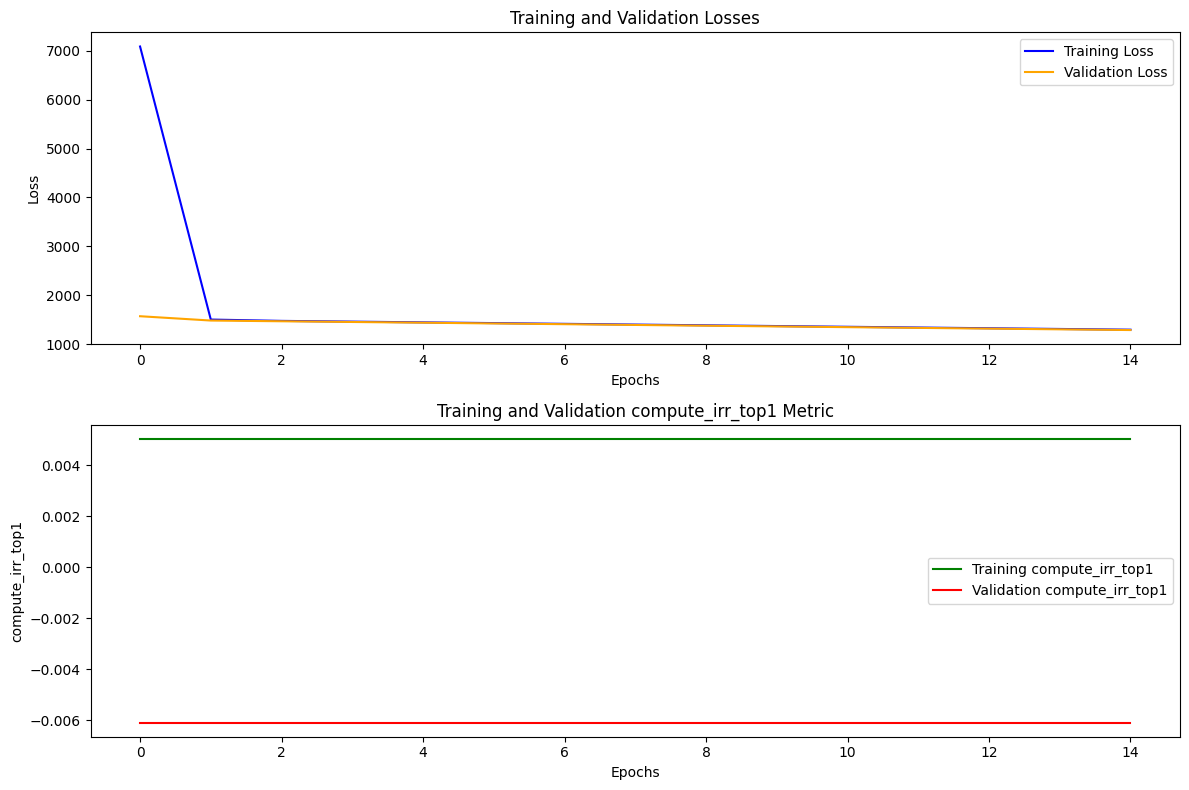

In [ ]:
import pickle
import matplotlib.pyplot as plt


best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    best_model = tuner.hypermodel.build(best_hps)
    best_model.build((None, x_train.shape[1], x_train.shape[2], x_train.shape[3]))
    best_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
        loss=lambda y_true, y_pred: optimized_custom_loss_function(y_true, y_pred, best_model),
        metrics=metrics
    )


history = best_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, batch_size=1)
test_results = best_model.evaluate(x_test, y_test)
print(f"Test Results: {test_results}")

# Print the best hyperparameter combination (for your reference)
print("Best Hyperparameter Combination:")
print(f"Filters: {best_hps.get('filters')}")
print(f"Kernel Size: {best_hps.get('kernel_size')}")
print(f"Stride: {best_hps.get('stride')}")
print(f"Layers: {best_hps.get('layers')}")
print(f"Activation: {best_hps.get('activation')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Alpha: {best_hps.get('alpha')}")
print(f"Lambda: {best_hps.get('lambda')}")
print(f"Kernel Initializer: {best_hps.get('kernel_initializer')}")

# Dynamically extract training history metrics from the history object
train_loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
train_pointwise_regression_loss = history.history.get('pointwise_regression_loss', [])
val_pointwise_regression_loss = history.history.get('val_pointwise_regression_loss', [])
train_compute_irr_top1 = history.history.get('compute_irr_top1', [])
val_compute_irr_top1 = history.history.get('val_compute_irr_top1', [])
train_compute_mrr_top1 = history.history.get('compute_mrr_top1', [])
val_compute_mrr_top1 = history.history.get('val_compute_mrr_top1', [])

# Save the results to a dictionary
results = {
    'best_hyperparameters': {
        'filters': best_hps.get('filters'),
        'kernel_size': best_hps.get('kernel_size'),
        'stride': best_hps.get('stride'),
        'layers': best_hps.get('layers'),
        'learning_rate': best_hps.get('learning_rate'),
        'alpha': best_hps.get('alpha'),
        'lambda': best_hps.get('lambda')
    },
    'train_loss': train_loss,
    'val_loss': val_loss,
    'test_loss': test_results[0],  # Assuming test_results is available
    'train_metrics': {
        'pointwise_regression_loss': train_pointwise_regression_loss,
        'compute_irr_top1': train_compute_irr_top1,
        'compute_mrr_top1': train_compute_mrr_top1
    },
    'val_metrics': {
        'val_pointwise_regression_loss': val_pointwise_regression_loss,
        'val_compute_irr_top1': val_compute_irr_top1,
        'val_compute_mrr_top1': val_compute_mrr_top1
    },
    'test_metrics': {
        'pointwise_regression_loss': test_results[1],  # Assuming test_results indices exist
        'compute_irr_top1': test_results[2],
        'compute_mrr_top1': test_results[3]
    }
}

# Save the dictionary to a pickle file
with open("/content/drive/MyDrive/Colab Notebooks/GNN/Baseline 2: TCN Stacked/Best_hp_BM2_10(Simplified + Normalization).pkl", "wb") as f:
    pickle.dump(results, f)

# Plot the training and validation losses and the compute_irr_top1 metric
plt.figure(figsize=(12, 8))

# Subplot for Losses
plt.subplot(2, 1, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Subplot for compute_irr_top1 Metric
plt.subplot(2, 1, 2)
plt.plot(train_compute_irr_top1, label='Training compute_irr_top1', color='green')
plt.plot(val_compute_irr_top1, label='Validation compute_irr_top1', color='red')
plt.xlabel('Epochs')
plt.ylabel('compute_irr_top1')
plt.title('Training and Validation compute_irr_top1 Metric')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import pickle

# Load the results from the pickle file
with open("/content/drive/MyDrive/Colab Notebooks/GNN/Baseline 2: TCN Stacked/Best_hp_BM2_10(Simplified + Normalization).pkl", "rb") as f:
    loaded_results = pickle.load(f)

# Extract the loaded hyperparameters
loaded_filters = loaded_results['best_hyperparameters']['filters']
loaded_kernel_size = loaded_results['best_hyperparameters']['kernel_size']
loaded_stride = loaded_results['best_hyperparameters']['stride']
loaded_layers = loaded_results['best_hyperparameters']['layers']
loaded_learning_rate = loaded_results['best_hyperparameters']['learning_rate']
loaded_alpha = loaded_results['best_hyperparameters']['alpha']
loaded_lambda = loaded_results['best_hyperparameters']['lambda']

# Extract the loaded losses
loaded_train_loss = loaded_results['train_loss']
loaded_val_loss = loaded_results['val_loss']
loaded_test_loss = loaded_results['test_loss']

# Extract the loaded metrics
loaded_train_metrics = loaded_results['train_metrics']
loaded_val_metrics = loaded_results['val_metrics']
loaded_test_metrics = loaded_results['test_metrics']

# Print the loaded hyperparameters
print("\nLoaded Best Hyperparameter Combination:")
print(f"Loaded Filters: {loaded_filters}")
print(f"Loaded Kernel Size: {loaded_kernel_size}")
print(f"Loaded Stride: {loaded_stride}")
print(f"Loaded Layers: {loaded_layers}")
print(f"Loaded Learning Rate: {loaded_learning_rate}")
print(f"Loaded Alpha: {loaded_alpha}")
print(f"Loaded Lambda: {loaded_lambda}")

# Print the loaded losses
print("\nLoaded Losses:")
print(f"Loaded Training Loss: {loaded_train_loss}")
print(f"Loaded Validation Loss: {loaded_val_loss}")
print(f"Loaded Test Loss: {loaded_test_loss}")

# Print the loaded metrics
print("\nLoaded Training Metrics:")
for metric_name, metric_values in loaded_train_metrics.items():
    print(f"{metric_name}: {metric_values}")

print("\nLoaded Validation Metrics:")
for metric_name, metric_values in loaded_val_metrics.items():
    print(f"{metric_name}: {metric_values}")

print("\nLoaded Test Metrics:")
for metric_name, metric_value in loaded_test_metrics.items():
    print(f"{metric_name}: {metric_value}")



Loaded Best Hyperparameter Combination:
Loaded Filters: 64
Loaded Kernel Size: 3
Loaded Stride: 1
Loaded Layers: 5
Loaded Learning Rate: 0.001
Loaded Alpha: 1.5
Loaded Lambda: 0.005

Loaded Losses:
Loaded Training Loss: [7086.96728515625, 1503.1917724609375, 1476.0877685546875, 1460.8858642578125, 1445.8455810546875, 1430.8460693359375, 1415.662109375, 1400.6439208984375, 1385.6732177734375, 1370.3568115234375, 1355.3760986328125, 1340.4267578125, 1325.65966796875, 1310.9134521484375, 1296.1785888671875]
Loaded Validation Loss: [1571.32666015625, 1482.9886474609375, 1468.1968994140625, 1453.6324462890625, 1439.1402587890625, 1423.44091796875, 1408.5150146484375, 1392.82763671875, 1377.755859375, 1362.6785888671875, 1347.7938232421875, 1332.8951416015625, 1318.1181640625, 1303.4547119140625, 1288.71923828125]
Loaded Test Loss: 1288.6903076171875

Loaded Training Metrics:
pointwise_regression_loss: [5548.06640625, 10.783100128173828, 0.988050103187561, 0.5214324593544006, 0.348609894514

In [ ]:
import tensorflow as tf
import time

# Dummy Inputs
batch_size = 32
num_stocks = 100
timesteps = 50
features = 8

inputs = tf.random.normal((batch_size, num_stocks, timesteps, features))

# Define dummy TCN blocks (Each stock has its own unique block)
class DummyTCNBlock(tf.keras.layers.Layer):
    def call(self, x):
        return tf.reduce_mean(x, axis=-1, keepdims=True)  # Dummy operation

# Store TCN blocks in a dictionary (indexed by Python ints)
tcn_a_blocks = {i: DummyTCNBlock() for i in range(num_stocks)}

# **Python Loop Approach**
@tf.function
def loop_approach(inputs):
    start_time = tf.timestamp()

    stock_outputs = []
    for i in range(num_stocks):
        stock_input = inputs[:, i, :, :]  # Slice along stock dimension
        stock_outputs.append(tcn_a_blocks[i](stock_input))  # Apply corresponding TCN block

    tcn_a_outputs = tf.stack(stock_outputs, axis=1)  # Stack along stock dimension
    end_time = tf.timestamp()

    return tcn_a_outputs, end_time - start_time

# **Vectorized Approach using tf.map_fn with tf.switch_case**
@tf.function
def vectorized_map_approach(inputs):
    start_time = tf.timestamp()

    def apply_tcn(index, stock_inputs):
        # tf.switch_case requires a function for each index
        branch_fns = {i: lambda si=stock_inputs, i=i: tcn_a_blocks[i](si) for i in range(num_stocks)}
        return tf.switch_case(index, branch_fns)

    indices = tf.range(num_stocks, dtype=tf.int32)

    # Use tf.map_fn to apply each TCN block to the corresponding stock
    tcn_a_outputs = tf.map_fn(
        lambda i: apply_tcn(i, inputs[:, i, :, :]), indices, dtype=tf.float32
    )

    # Reshape back to match the expected output shape
    tcn_a_outputs = tf.transpose(tcn_a_outputs, perm=[1, 0, 2, 3])  # Correct stock dimension
    end_time = tf.timestamp()

    return tcn_a_outputs, end_time - start_time

# Run and measure time
loop_outputs, loop_time = loop_approach(inputs)
vectorized_outputs, vectorized_time = vectorized_map_approach(inputs)

print(f"Python Loop Execution Time: {loop_time.numpy()} seconds")
print(f"Vectorized Execution Time: {vectorized_time.numpy()} seconds")


Instructions for updating:
Use fn_output_signature instead


Python Loop Execution Time: 1.9073486328125e-06 seconds
Vectorized Execution Time: 5.0067901611328125e-06 seconds
